# Generalisation of conceptual model presented in Nicholson et al. 2021 Nature communciations


<b>The following code is used to generate figure 4 of "Storms drive outgassing of CO2 in the subpolar Southern Ocean"
Author: Sarah Nicholson </b>

contact: snicholson@csir.co.za

Date: 03-Nov-2021

<h1>

We have applied the box model for high-frequency variability of surface ocean pCO2 (defined in Eq. 2-4) across a dynamically representative zonal band. We used 3-hourly reanalysis winds to compute u* using winds from the Japanese 55-year Reanalysis (JRA-55-do68); monthly mean MLD were estimated using a density threshold of 0.03 kg m-3 from density field derived from EN 4.2.1 interpolated fields of temperature and salinity; and temporal varying (i.e., monthly mean) lateral and vertical gradients from the climatology of AT and DIC were taken from 41,42. We translate wind variability via friction velocity (u*) into mixing layer depth (XLD) variability assuming the strong relationship between u* and XLD holds true for these dynamically comparable regions (Fig. S5 and Fig. S6). Intermittent high-frequency supplies of DIC and AT due to high-frequency Ekman advection and wind-driven vertical entrainment were computed following (Eq. 2-4) and the anomalies of DIC and AT were iteratively added to baseline climatological means of DIC and AT. Changes in temperature were not included as the focus was on non-thermal drivers. Finally, pyCO2SYS67 was used to compute pCO2-DIC from the physically-driven changes in AT and DIC to generate high-frequency temporal variability of pCO2-DIC anomalies across the Subpolar Southern Ocean (as shown in Fig. 4). 

<b>Dynamical model for Highfrequency pCO2:</b>

pCO_(2-DIC)' = G(Y_Ek (DIC,At )  + Z_ent (DIC,At ))    


<b>Ekman displacement Y_Ek (DIC,At ): </b>

Y_Ek = ∫ -v_Ek  dt ×  ∂(DIC,AT )/∂y	                                                              
Where the meridional Ekman velocity is defined by v_Ek  = -τ_x/(ρ_(sw) XLD f),  τ_x  is the zonal surface wind 

<b>Entrainment Z_ent (DIC,At ):</b>


Z_ent  = ∫ H × (1/MLD_max × (C_deep - C_surf )× ∂XLD/∂t)dt		              

where using x =  XLD/〖MLD〗_max ,

H= 1,if x > 1  and  ∂XLD/∂t  > 0,	

H = 0,if x < 1 or  ∂XLD/∂t  < 0, 


In [12]:
%pylab inline
import xarray as xr
import pandas as pd
import cmocean as cm
from scipy import stats
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy import crs as ccrs, feature as cfeature
import glidertools as gt
from scipy import integrate


Populating the interactive namespace from numpy and matplotlib


/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy



# Load subpolar mask 

This mask is the region generalised defined by maximum co2 outgassing and maximum ice extent 

In [2]:

m = xr.open_dataarray('../Data/Generalisation/zonal_masked_region.nc')
m 

<xarray.DataArray (lat: 28, lon: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 -68.0 -67.0 -66.0 -65.0 ... -44.0 -43.0 -42.0 -41.0
  * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0

# Load Ekman and entrainment pCO2 anoms

## Load ekman displacement anoms 

In [3]:
# pco2dic gradient from estimated from pco2 after decomposition broullon:
grad_br2019 = xr.open_mfdataset('../Data/Generalisation/pco2_dic_dy_broullon.nc')
grad_br2019 = grad_br2019.__xarray_dataarray_variable__

# estimated using broullon gradients:
ek_br2019 = xr.open_mfdataset('../Data/Generalisation/pco2_dic_ekman_displacement_bruollon2019.nc')
ek_br2019 = ek_br2019.__xarray_dataarray_variable__

# ekman displacement apply constant gradient (1e-4 )
ek_anom = xr.open_mfdataset('../Data/Generalisation/ekanoms_10dayroll_2019_2020_25km_3hrly_jra.nc')
ekanomConstant = ek_anom.__xarray_dataarray_variable__*1e-4


## Load in the Entrainment pco2 anomalies ALL year broullon:

In [4]:
pco2_anom_en_br = xr.open_dataarray('../Data/Generalisation/entrainment_pco2_en421_broullon_100m_reservoirs_2019maxmld.nc')

## pco2 dic anomalies estimate: 

In [5]:
# Y_Ek + Z_ent:
total_2019 = pco2_anom_en_br + ek_br2019
total_2019_no_entrain = pco2_anom_en_br

# 7-Day variance:
total_2019_var = total_2019.resample(time='7D',loffset=True).var()
total_2019_entrain_var = pco2_anom_en_br.resample(time='7D',loffset=True).var()
total_2019_ekman_var = ek_br2019.resample(time='7D',loffset=True).var()


# % variance due to ekman?
ek_percent = (total_2019_var.mean('time')- total_2019_entrain_var.mean('time'))/total_2019_var.mean('time')*100


# Load the circumnavigating SAILDRONE Data for comparison
Data provided here: Sutton, A. J. et al. Surface underway measurements of partial pressure of carbon dioxide (pCO2), sea surface temperature, sea surface salinity and other parameters from Autonomous Surface Vehicle ASV_Saildrone1020 (EXPOCODE 32DB20190119) in the South Atlantic Ocean, South Pac. NOAA Natl. Centers Environ. Information. (2020) doi:https://doi.org/10.25921/6zja-cg56)


In [6]:
sdrone = pd.read_csv('../Data/SO_Saildrone_ASVCO2_preliminary.csv',delimiter=',',parse_dates=['Date'])

## Clean up SD data

In [7]:
# 1) Sort out SD dates
dates_sd = []
for i in np.arange(sdrone.Date.size):
    if len(sdrone.Date[i][:]) <= 7:
        datstr = sdrone.Date[i][-4:] +'-' +sdrone.Date[i][1:3]+'-0'+ sdrone.Date[i][0:1] + ' ' + sdrone.Time[i]

    else:
        datstr = sdrone.Date[i][-4:] +'-' +sdrone.Date[i][3:4]+'-'+sdrone.Date[i][0:2] + ' '+ sdrone.Time[i]
    
    dates_sd.append(pd.to_datetime(datstr))

sdrone['Dates'] =dates_sd
sdrone = sdrone.set_index('Dates')

In [8]:
# Remove outliers
masksd = (sdrone.Latitude < -46.9) & (sdrone['pCO2 SW (sat) uatm'].diff()<np.nanpercentile(sdrone['pCO2 SW (sat) uatm'].diff(),96)) & (sdrone['pCO2 SW (sat) uatm'].diff()>-np.nanpercentile(sdrone['pCO2 SW (sat) uatm'].diff(),95))
sdroneC = sdrone[100:].copy()#[masksd]
sdroneC = sdroneC[masksd]


/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/glidertools/helpers.py:61: GliderToolsWarning:

Primary input variable is not xr.DataArray data type - no metadata to pass on.



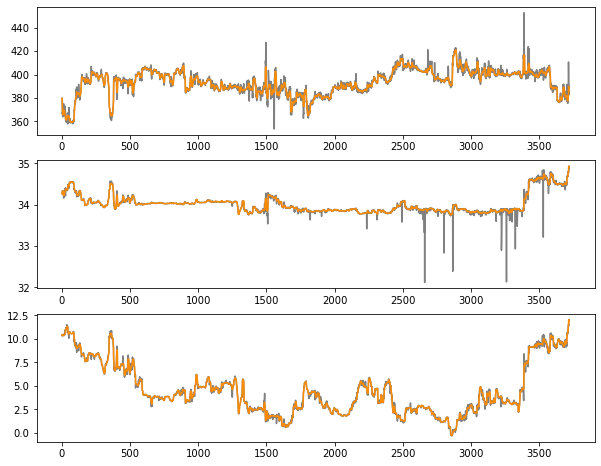

In [9]:
salt_despike,spike = gt.cleaning.despike(sdroneC.Salinity,10)
temp_despike,spike = gt.cleaning.despike(sdroneC['SST (C)'],10)
pco2_despike,spike = gt.cleaning.despike(sdroneC['pCO2 SW (sat) uatm'],10)

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plot(sdroneC['pCO2 SW (sat) uatm'].values,color='grey')#.diff())
plot(pco2_despike,color='darkorange')

plt.subplot(3,1,2)
plot(sdroneC.Salinity.values,color='grey')#.diff())
plot(salt_despike,color='darkorange')

plt.subplot(3,1,3)
plot(sdroneC['SST (C)'].values,color='grey')#.diff())
plot(temp_despike,color='darkorange')

sdroneC['salt_despike'] = salt_despike
sdroneC['sst_despike'] = temp_despike
sdroneC['pco2_despike'] = pco2_despike

In [10]:
sdrone = sdroneC.resample('3H',loffset=True).mean()

/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")




## SD pCO2sea decomposition

In [13]:
# calculate the change in pco2 due to temperature 
#-------------------------------------------------
# Initialse variables 
sdrone_dpCO2_sst = np.zeros((sdrone['pco2_despike'].size))
sdrone_dpCO2 = np.zeros((sdrone['sst_despike'].size))

# loop to calculat the change in pco2 due to temperature 

for i in range(sdrone['pCO2 SW (sat) uatm'].size-1):
    
    sdrone_dpCO2_sst[i+1] = sdrone['pco2_despike'].bfill().values[i]*0.0423*((sdrone['sst_despike'].bfill().values[i+1] -sdrone['sst_despike'].bfill().values[i]))
    
    sdrone_dpCO2[i+1] =  sdrone['pco2_despike'].bfill().values[i+1] - sdrone['pco2_despike'].bfill().values[i]
    
# NON THERMAL COMPONENT OF dPCO2:
sdrone_dpCO2_dic = sdrone_dpCO2 - sdrone_dpCO2_sst 
sdrone['sdrone_pCO2_sst'] =  np.insert(integrate.cumtrapz(sdrone_dpCO2_sst[:]),0,np.nan)                            
sdrone['sdrone_pCO2_dic'] =  np.insert(integrate.cumtrapz(sdrone_dpCO2_dic[:]),0,np.nan)   


Text(0.5, 1.0, 'Sailtdrone pCO2 decomposition')

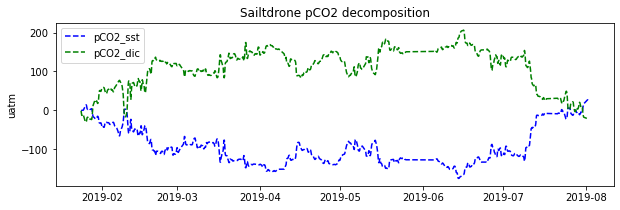

In [14]:
plt.figure(figsize=(10,3))
masksd1 = np.isnan(sdrone['SST (C)'])#(sdrone.Latitude < -46.9) & (sdrone['pCO2 SW (sat) uatm'].diff()<np.nanpercentile(sdrone['pCO2 SW (sat) uatm'].diff(),95)) & (sdrone['pCO2 SW (sat) uatm'].diff()>-np.nanpercentile(sdrone['pCO2 SW (sat) uatm'].diff(),95))
sdrone1 = sdrone[~masksd1].copy()
plot(sdrone[~masksd1].sdrone_pCO2_sst,label='pCO2_sst',ls='--',color='b')
plot(sdrone[~masksd1].sdrone_pCO2_dic,ls='--',label='pCO2_dic',color='g')

plt.legend()
plt.ylabel('uatm')
plt.title('Sailtdrone pCO2 decomposition')

## pCO2dic' anoms

In [15]:
sdrone['pCO2_dic_anom'] = sdrone.sdrone_pCO2_dic - sdrone.sdrone_pCO2_dic.rolling(8*10,center=True,min_periods=2).mean()


# Step 3: Collocate Saildrone data
## Find nearest value for ekman and entrainment estimate

In [16]:
## Find 7 day variance and colocate
sdrone5d = sdrone.resample('7D',loffset=True).median()

/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning:

'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")




In [18]:
estimate_sdrone_var=np.zeros((sdrone5d['pCO2 SW (sat) uatm'].size))

for i in np.arange(1,sdrone5d['pCO2 SW (sat) uatm'].size-1):#sdrone['pCO2 SW (sat) uatm'].size):
    
    if (np.isnan(sdrone5d['Longitude'][i])==True)| (sdrone5d['Latitude'][i] > -41) | (sdrone5d['Longitude'][i] ==0.0):# (i > 74) & (i< 80):
        estimate_sdrone_var[i] = np.nan 
    else:
        
        estimate_sdrone_var[i] = total_2019_var.sel(time = pd.to_datetime(sdrone5d.index.values[i]),lat = sdrone5d.Latitude.values[i],lon=sdrone5d.Longitude.values[i]%360, method='nearest')


# Nature comms final Figure

In [19]:
cm1 = 1/2.54  # centimeters in inches
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 7

fig = plt.figure(figsize=(7,6))
fname = '../Data/10m_coastline.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                 ccrs.PlateCarree(), lw=1, edgecolor='k', facecolor='white')


<Figure size 504x432 with 0 Axes>

/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:19: FutureWarning:

'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")


/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:20: FutureWarning:

'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")


/home/snicholson1/.conda/envs/py3/lib/python3.7/site-packages/ipykernel/__main__.py:22: FutureWarning:

'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>>

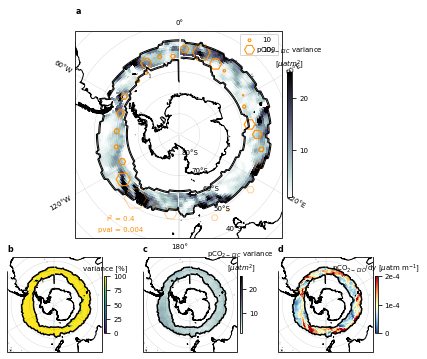

In [22]:
fig = plt.figure(figsize=(18*cm1, 15*cm1))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=6)
tf=7


ax = fig.add_subplot(gs[0:2,1:5],projection = ccrs.Stereographic(central_latitude=-90))
ax.set_extent([-240, 80, -80, -42], crs=ccrs.PlateCarree())
ax.add_feature(shape_feature)
from cartopy.util import add_cyclic_point
varpco2 = np.ma.masked_equal(total_2019_var.mean('time'),0)*m[4:,:]
mg =m
varpco21, lon1 = add_cyclic_point(varpco2, coord=mg.lon)
mesh = ax.pcolormesh(lon1,mg.lat[4:],varpco21,vmin=1,vmax=25,cmap='bone_r',transform = ccrs.PlateCarree())
cb = plt.colorbar(mesh, orientation = 'vertical', shrink=0.6, aspect = 25, pad = 0.02)
cb.ax.set_title('pCO$_{2-DIC}$ variance \n[$\mu$$atm^2$]',fontsize=7)
cb.set_ticks([10,20])
cb.set_ticklabels([10,20])
ax.contour(m.lon,m.lat,m,1 ,transform = ccrs.PlateCarree(),zorder=100,linewidths=1,colors='black')
sc = ax.scatter(sdrone.Longitude.resample('7D',loffset=True).mean(),sdrone.Latitude.resample('7D',loffset=True).mean(),s=sdrone['pCO2_dic_anom'].rolling(8*2,center=True,min_periods=2).mean().resample('7D',loffset=True).var(),transform = ccrs.PlateCarree(),marker='H',edgecolors='darkorange',linewidth=1,facecolors='None',alpha=0.4);#plt.colorbar()
sc = ax.scatter(sdrone.Longitude.resample('7D',loffset=True).mean()[3:-5],sdrone.Latitude.resample('7D',loffset=True).mean()[3:-5],s=sdrone['pCO2_dic_anom'].rolling(8*2,center=True,min_periods=2).mean().resample('7D',loffset=True).var()[3:-5],transform = ccrs.PlateCarree(),marker='H',edgecolors='darkorange',linewidth=1,facecolors='None');#plt.colorbar()
x = estimate_sdrone_var[3:-5] # ignore edge points that lie outside region
y = sdrone['pCO2_dic_anom'].resample('7D',loffset=True).var()[3:-5]  
slope, intercept, r_value, p_value, std_err = stats.linregress(x[~numpy.isnan(x) & ~numpy.isnan(y)],y[~numpy.isnan(x) & ~numpy.isnan(y)])
ax.text(220,-38,'r$^2$ = '+str(round(r_value**2,1)),fontsize=tf,transform = ccrs.PlateCarree(),color='darkorange')
ax.text(220,-33,'pval = '+str(round(p_value,3)),fontsize=tf,transform = ccrs.PlateCarree(),color='darkorange')
ax.set_title('a',fontweight='bold',loc='left',fontsize=8)
gll = ax.scatter([],[], s=10, marker='H',edgecolors='darkorange',linewidth=1,facecolors='None',transform = ccrs.PlateCarree())
gl = ax.scatter([],[], s=100, marker='H',edgecolors='darkorange',linewidth=1,facecolors='None',transform = ccrs.PlateCarree())
ax.legend((gll,gl),
       ('10','100'),scatterpoints=1,
       loc='upper right',
       ncol=1,
       fontsize=7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.2, color='black', alpha=0.5, linestyle='--',draw_labels='True') 


#=================================================
ax1 = fig.add_subplot(gs[2,0:2],projection = ccrs.Stereographic(central_latitude=-90))
mesh = ax1.pcolormesh(m.lon,m.lat[4:],np.ma.masked_equal(ek_percent*m[4:,:],0),vmin=0,vmax=100,cmap='viridis',transform = ccrs.PlateCarree())#cmap1)
ax1.add_feature(shape_feature, zorder=100)
ax1.contour(m.lon,m.lat,m,1 ,transform = ccrs.PlateCarree(),zorder=100,linewidths=1,colors='black')
cb = plt.colorbar(mesh, orientation = 'vertical', shrink=0.6, aspect = 25, pad = 0.02)
cb.ax.set_title('variance [%]',fontsize=7)
plt.title('b',loc='left',fontsize=8,fontweight='bold')#,position=(0.1,.85),fontweight='bold')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=.2, color='black', alpha=0.5, linestyle='--') 


#=================================================
# pCO$_{2DIC}$No gradient variance
ax1 = fig.add_subplot(gs[2,2:4],projection = ccrs.Stereographic(central_latitude=-90))
mesh = ax1.pcolormesh(mg.lon,mg.lat,np.ma.masked_equal(ekanomConstant.resample(time='7D',loffset=True).var().mean('time')*mg,0),cmap='bone_r',transform = ccrs.PlateCarree(),vmin=2,vmax=25)#cmap1)
ax1.add_feature(shape_feature, zorder=100)
ax1.contour(m.lon,m.lat,m,1 ,transform = ccrs.PlateCarree(),zorder=100,linewidths=1,colors='black')
cb = plt.colorbar(mesh, orientation = 'vertical', shrink=0.6, aspect = 25, pad = 0.02)
cb.ax.set_title('pCO$_{2-DIC}$ variance \n [$\mu$$atm^2$]',fontsize=7)
plt.title('c  ',loc='left',fontsize=8,fontweight='bold')#,position=(0.1,.85),fontweight='bold')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=.2, color='black', alpha=0.5, linestyle='--') 


#=================================================
#pCO$_{2DIC}$ gradient 
ax1 = fig.add_subplot(gs[2,4:6],projection = ccrs.Stereographic(central_latitude=-90))
mesh = ax1.pcolormesh(m.lon,m.lat,np.ma.masked_equal(np.abs(grad_br2019.mean('time'))*m[:,:],0),cmap='RdYlBu_r',transform = ccrs.PlateCarree(),vmin=0,vmax=2e-4)#cmap1)
ax1.add_feature(shape_feature, zorder=100)
ax1.contour(m.lon,m.lat,m,1 ,transform = ccrs.PlateCarree(),zorder=100,linewidths=1,colors='black')
cb = plt.colorbar(mesh, orientation = 'vertical', shrink=0.6, aspect = 25, pad = 0.02, ticks=[0, 1e-4,2e-4])
cb.ax.set_yticklabels(['0', '1e-4', '2e-4'])
cb.ax.set_title('pCO$_{2-DIC}$/dy [$\mu$atm m$^{-1}$]',fontsize=7)
plt.title('d ',loc='left',fontsize=8, fontweight='bold')#,position=(0.1,.85),fontweight='bold')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=.2, color='black', alpha=0.5, linestyle='--') #draw_labels=True)


#plt.savefig('Figure_4_natcomms_2021.pdf')
